##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 3D Style Transfer

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to implement style transfer from a textured 3D model and a style image onto a new texture for the 3D model by using a [Differentiable Image Parameterization](https://distill.pub/2018/differentiable-parameterizations/#section-style-transfer-3d). 

<!--![](https://storage.googleapis.com/tensorflow-lucid/notebooks/styletransfer-3d/header.jpg =724x)-->

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/ercaronte/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup.

## Install, Import, Initialize OpenGL, and load a CNN model

This notebook uses OpenGL and thus **requires** a GPU, unlikely most of  our notebooks.
You can check whether your GPU is available and configured correctly for tensorflow:

In [1]:
import tensorflow as tf

assert tf.config.list_physical_devices('GPU')

If the above assert statement fails, you can always run the notebook on colab and use a free GPU by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

In [2]:
!pip install --quiet git+https://github.com/ercaronte/lucid.git
#!pip install --quiet git+https://github.com/tensorflow/lucid.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 378.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
import io
import sys
from string import Template
from pathlib import Path

import numpy as np
import PIL.Image
import matplotlib.pylab as pl
from google.colab import files

from IPython.display import clear_output, display, Image, HTML

from lucid.misc.gl.glcontext import create_opengl_context
import OpenGL.GL as gl

from lucid.misc.gl import meshutil
from lucid.misc.gl import glrenderer
import lucid.misc.io.showing as show
import lucid.misc.io as lucid_io
from lucid.misc.tfutil import create_session

from lucid.modelzoo import vision_models
from lucid.optvis import objectives
from lucid.optvis import param
from lucid.optvis.style import StyleLoss, mean_l1_loss
from lucid.optvis.param.spatial import sample_bilinear

You can check the installed version of OpenGL:

In [4]:
create_opengl_context()
gl.glGetString(gl.GL_VERSION)

b'4.6.0 NVIDIA 460.32.03'

In [5]:
model = vision_models.InceptionV1()
model.load_graphdef()

## Loading 3D model

Let's download some 3D models first. This is similar to the steps in the [3D Feature Visualization notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/texture_synth_3d.ipynb) if you're keen on the details and haven't completed that notebook yet.

In [7]:
TEXTURE_SIZE = 1024

In [ ]:
# commented out this cell since the deepdream gs bucket is no longer up
#!gsutil cp gs://deepdream/article_models.zip . && \
# unzip -qo article_models.zip && \
# ls -al article_models && \
# cat article_models/readme.txt

In [6]:
!wget https://github.com/ercaronte/lucid/raw/master/notebooks/static/article_models.zip && \
 unzip -qo article_models.zip && \
 ls -al article_models && \
 cat article_models/readme.txt

--2023-01-23 22:47:39--  https://github.com/ercaronte/lucid/raw/master/notebooks/static/article_models.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ercaronte/lucid/master/notebooks/static/article_models.zip [following]
--2023-01-23 22:47:40--  https://raw.githubusercontent.com/ercaronte/lucid/master/notebooks/static/article_models.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3419863 (3.3M) [application/zip]
Saving to: ‘article_models.zip’

article_models.zip  100%[===================>]   3.26M  --.-KB/s    in 0.03s   

2023-01-23 22:47:40 (119 MB/s) - ‘article_models.zip’ saved

In [ ]:
def prepare_image(fn, size=None):
    data = lucid_io.reading.read(fn)
    im = PIL.Image.open(io.BytesIO(data)).convert('RGB')
    if size:
        im = im.resize(size, PIL.Image.ANTIALIAS)
    return np.float32(im)/255.0

In [ ]:
mesh = meshutil.load_obj('article_models/bunny.obj')
mesh = meshutil.normalize_mesh(mesh)

original_texture = prepare_image('article_models/bunny.png', (TEXTURE_SIZE, TEXTURE_SIZE))

In [ ]:
#style_url = 'https://upload.wikimedia.org/wikipedia/commons/d/db/RIAN_archive_409362_Literaturnaya_Gazeta_article_about_YuriGagarin%2C_first_man_in_space.jpg' # removed from wikimedia
style_url = 'https://upload.wikimedia.org/wikipedia/commons/1/19/Corriere_5_marzo_1876.jpg'
style = prepare_image(style_url)
show.image(style, fmt='jpeg')

Output hidden; open in https://colab.research.google.com to view.

## Texture Synthesis

In [ ]:
renderer = glrenderer.MeshRenderer((512, 512))

In [ ]:
googlenet_style_layers = [
    'conv2d2',
    'mixed3a',
    'mixed3b',
    'mixed4a',
    'mixed4b',
    'mixed4c',
]

googlenet_content_layer = 'mixed3b'

In [ ]:
content_weight = 100.0
# Style Gram matrix weighted average decay coefficient
style_decay = 0.95

sess = create_session(timeout_sec=0)

# t_fragments is used to feed rasterized UV coordinates for the current view.
# Channels: [U, V, _, Alpha]. Alpha is 1 for pixels covered by the object, and
# 0 for background.
t_fragments = tf.compat.v1.placeholder(tf.float32, [None, None, 4])
t_uv = t_fragments[...,:2]
t_alpha = t_fragments[...,3:]

# Texture atlas to optimize
t_texture = param.image(TEXTURE_SIZE, fft=True, decorrelate=True)[0]

# Variable to store the original mesh texture used to render content views
content_var = tf.Variable(tf.zeros([TEXTURE_SIZE, TEXTURE_SIZE, 3]), trainable=False)

# Sample current and original textures with provided pixel data
t_joined_texture = tf.concat([t_texture, content_var], -1)
t_joined_frame = sample_bilinear(t_joined_texture, t_uv) * t_alpha
t_frame_current, t_frame_content = t_joined_frame[...,:3], t_joined_frame[...,3:]
t_joined_frame = tf.stack([t_frame_current, t_frame_content], 0)

# Feeding the rendered frames to the Neural Network
t_input = tf.compat.v1.placeholder_with_default(t_joined_frame, [None, None, None, 3])
model.import_graph(t_input)

# style loss
style_layers = [sess.graph.get_tensor_by_name('import/%s:0'%s)[0] for s in googlenet_style_layers]
# L1-loss seems to be more stable for GoogleNet
# Note that we use style_decay>0 to average style-describing Gram matrices
# over the recent viewports. Please refer to StyleLoss for the details.
sl = StyleLoss(style_layers, style_decay, loss_func=mean_l1_loss)

# content loss
content_layer = sess.graph.get_tensor_by_name('import/%s:0'%googlenet_content_layer)
content_loss = mean_l1_loss(content_layer[0], content_layer[1]) * content_weight

# setup optimization
total_loss = content_loss + sl.style_loss
t_lr = tf.constant(0.05)
trainer = tf.compat.v1.train.AdamOptimizer(t_lr)
train_op = trainer.minimize(total_loss)

init_op = tf.compat.v1.global_variables_initializer()
loss_log = []

def reset(style_img, content_texture):
  del loss_log[:]
  init_op.run()
  sl.set_style({t_input: style_img[None,...]})
  content_var.load(content_texture)

def run(mesh, step_n=400):
  for i in range(step_n):
    fragments = renderer.render_mesh(
        modelview=meshutil.sample_view(10.0, 12.0),
        position=mesh['position'], uv=mesh['uv'],
        face=mesh['face'])
    _, loss = sess.run([train_op, [content_loss, sl.style_loss]], {t_fragments: fragments})
    loss_log.append(loss)
    if i==0 or (i+1)%50 == 0:
      clear_output()
      last_frame, last_content = sess.run([t_frame_current, t_frame_content], {t_fragments: fragments})
      show.images([last_frame, last_content], ['current frame', 'content'])
    if i==0 or (i+1)%10 == 0:
      print(len(loss_log), loss)


/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
reset(style, original_texture)

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.



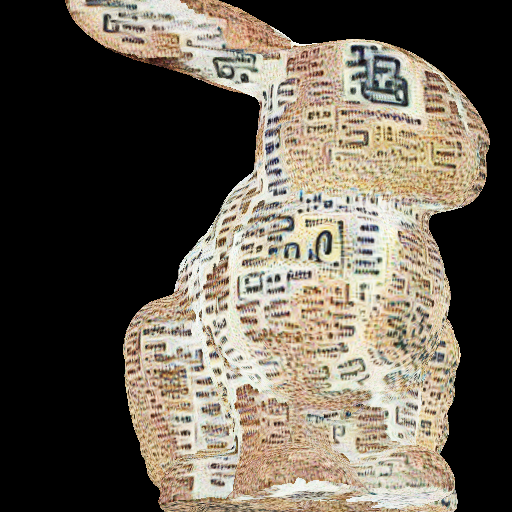
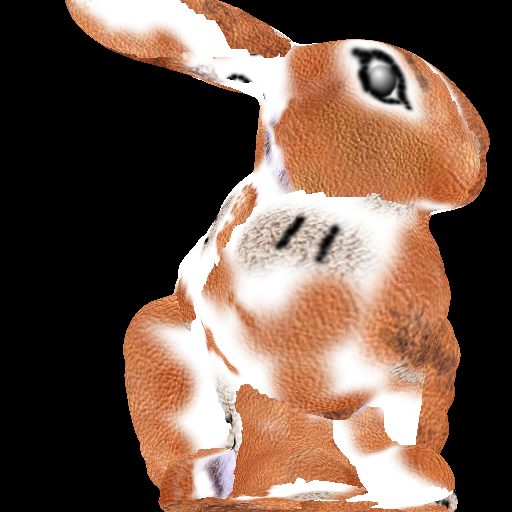

400 [1179.7976, 1950.2844]


In [ ]:
run(mesh)

Since this is such a stochastic optimization procedure, it's good to sanity check that we observe the loss going down.

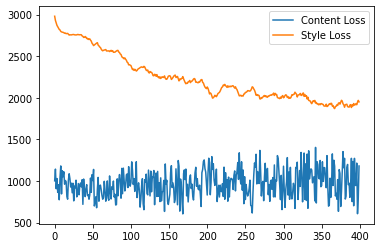

In [ ]:
pl.plot(loss_log);
pl.legend(['Content Loss', 'Style Loss'])
pl.show()

## Display Result

For the models with less complex textures—i.e. all except the bunny model—the content objective can be subtle. For example, in the case of the skull, its easiest to observe that the content loss is effective when viewing the [cranial sutures](https://en.wikipedia.org/wiki/Suture_(anatomy)). You can click and drag the output of the next cell to view the sides and top of the skull model.

In [ ]:
texture = t_texture.eval()
show.textured_mesh(mesh, texture)

Output hidden; open in https://colab.research.google.com to view.

You can also view the texture we optimized directly:

In [ ]:
show.image(texture, fmt='jpeg')

Output hidden; open in https://colab.research.google.com to view.

As an aside for the interested reader: the texture above still shows the original random initialization in the patches that aren't seen during the rendering. Can you think of a way to make these parts black, so the texture compresses better? 

*Hint: one approach could be to add a loss on the mean of the texture as a whole.* Give it a try!

# Batch texture generation

We are sometimes asked how we generate the data for interactive [Distill](https://distill.pub) articles. Usually the process is not very interesting, so we don't always include it in our notebooks. For the interrested reader, though, here is an example of running colab functions for many different input images.

These cells save assets locally on the colab runtime's VM. After running these cells, we use the `google.colab.files` module to download these assets to our development machines.

In [ ]:
styles = '''
starry  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/606px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
onwhite https://upload.wikimedia.org/wikipedia/commons/c/c4/Vassily_Kandinsky%2C_1923_-_On_White_II.jpg
mosaic  https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Fernand_L%C3%A9ger_-_Grand_parade_with_red_background_%28mosaic%29_1958_made.jpg/637px-Fernand_L%C3%A9ger_-_Grand_parade_with_red_background_%28mosaic%29_1958_made.jpg
points https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Robert_Delaunay%2C_1906%2C_Portrait_de_Metzinger%2C_oil_on_canvas%2C_55_x_43_cm%2C_DSC08255.jpg/449px-Robert_Delaunay%2C_1906%2C_Portrait_de_Metzinger%2C_oil_on_canvas%2C_55_x_43_cm%2C_DSC08255.jpg
scream https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/The_Scream.jpg/471px-The_Scream.jpg
noodles https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Noodles_and_eggs20170520_1035.jpg/526px-Noodles_and_eggs20170520_1035.jpg
newspaper https://upload.wikimedia.org/wikipedia/commons/d/db/RIAN_archive_409362_Literaturnaya_Gazeta_article_about_YuriGagarin%2C_first_man_in_space.jpg
birds https://canyouseedotca.files.wordpress.com/2016/01/mce-birds.jpg
cross https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Cross_stitch_detail.jpg/640px-Cross_stitch_detail.jpg
galaxy https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/NGC_4414_%28NASA-med%29.jpg/582px-NGC_4414_%28NASA-med%29.jpg
cd https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/CD_autolev_crop.jpg/480px-CD_autolev_crop.jpg
'''.split()
styles = list(zip(styles[::2], styles[1::2]))
HTML(" ".join('<p><a href="%s">%s</a></p>'%(url, name) for name, url in styles))

In [ ]:
from google.colab import files
from lucid.misc.io.writing import write


def export_mesh(name, mesh):
  data_to_save = {
      'position': mesh['position'].ravel(), 
      'uv': mesh['uv'].ravel(), 
      'face': np.uint32(mesh['face'].ravel())
  }
  for key, value in data_to_save.items():
    data = value.tobytes()
    filename = '%s_%s.3d'%(name, key)
    write(data, filename)

In [ ]:
for mesh_path in Path('article_models/').glob('*.obj'):
  mesh_name = mesh_path.stem
  print(mesh_name)
  
  tex_path = mesh_path.with_suffix('.jpg')
  if not tex_path.exists():
    tex_path = mesh_path.with_suffix('.png')
  
  mesh = meshutil.load_obj(str(mesh_path))
  mesh = meshutil.normalize_mesh(mesh)
  original_texture = prepare_image(str(tex_path), (TEXTURE_SIZE, TEXTURE_SIZE))
  
  export_mesh(mesh_name, mesh)
  lucid_io.save(original_texture, mesh_name+'_tex.jpg', quality=90)

  for style_name, url in styles:
    if style_name[0] == '#':
      continue
    style_img = prepare_image(url)
    reset(style_img, original_texture)
    run(mesh, step_n=800)
    texture = t_texture.eval()
    filename = '%s_tex_%s.jpg'%(mesh_name, style_name)
    lucid_io.save(texture, filename, quality=90)